In [1]:
import numpy as np 
import pandas as pd 
import os
import itertools

import re
from collections import Counter

import requests
import json


In [2]:
# Covid tweets
covid = pd.read_csv('covid19_tweets.csv')

# 
sentiment = pd.read_csv('sentiment.csv',encoding = 'latin', header=None, names=['target','id','time','query','usr','text'])

# country code with GDP
country_code = pd.read_csv('2014_world_gdp_with_codes.csv') 

#
us_state_code=pd.read_csv('abbr-name.csv',names=['state_code','state'])

In [3]:
covid.head(10)

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet
0,ᏉᎥ☻լꂅϮ,astroworld,wednesday addams as a disney princess keepin i...,2017-05-26 05:46:42,624,950,18775,False,2020-07-25 12:27:21,If I smelled the scent of hand sanitizers toda...,NaN,Twitter for iPhone,False
1,Tom Basile 🇺🇸,"New York, NY","Husband, Father, Columnist & Commentator. Auth...",2009-04-16 20:06:23,2253,1677,24,True,2020-07-25 12:27:17,Hey @Yankees @YankeesPR and @MLB - wouldn't it...,NaN,Twitter for Android,False
2,Time4fisticuffs,"Pewee Valley, KY",#Christian #Catholic #Conservative #Reagan #Re...,2009-02-28 18:57:41,9275,9525,7254,False,2020-07-25 12:27:14,@diane3443 @wdunlap @realDonaldTrump Trump nev...,['COVID19'],Twitter for Android,False
3,ethel mertz,Stuck in the Middle,#Browns #Indians #ClevelandProud #[]_[] #Cavs ...,2019-03-07 01:45:06,197,987,1488,False,2020-07-25 12:27:10,@brookbanktv The one gift #COVID19 has give me...,['COVID19'],Twitter for iPhone,False
4,DIPR-J&K,Jammu and Kashmir,🖊️Official Twitter handle of Department of Inf...,2017-02-12 06:45:15,101009,168,101,False,2020-07-25 12:27:08,25 July : Media Bulletin on Novel #CoronaVirus...,"['CoronaVirusUpdates', 'COVID19']",Twitter for Android,False
5,🎹 Franz Schubert,Новоро́ссия,🎼 #Новоро́ссия #Novorossiya #оставайсядома #S...,2018-03-19 16:29:52,1180,1071,1287,False,2020-07-25 12:27:06,#coronavirus #covid19 deaths continue to rise....,"['coronavirus', 'covid19']",Twitter Web App,False
6,hr bartender,"Gainesville, FL",Workplace tips and advice served up in a frien...,2008-08-12 18:19:49,79956,54810,3801,False,2020-07-25 12:27:03,How #COVID19 Will Change Work in General (and ...,"['COVID19', 'Recruiting']",Buffer,False
7,Derbyshire LPC,NaN,NaN,2012-02-03 18:08:10,608,355,95,False,2020-07-25 12:27:00,You now have to wear face coverings when out s...,NaN,TweetDeck,False
8,Prathamesh Bendre,NaN,"A poet, reiki practitioner and a student of law.",2015-04-25 08:15:41,25,29,18,False,2020-07-25 12:26:59,Praying for good health and recovery of @Chouh...,"['covid19', 'covidPositive']",Twitter for Android,False
9,Member of Christ 🇨🇳🇺🇸🇮🇳🇮🇩🇧🇷🇳🇬🇧🇩🇷🇺,👇🏻location at link below👇🏻,"Just as the body is one & has many members, & ...",2014-08-17 04:53:22,55201,34239,29802,False,2020-07-25 12:26:54,POPE AS GOD - Prophet Sadhu Sundar Selvaraj. W...,"['HurricaneHanna', 'COVID19']",Twitter for iPhone,False


In [4]:
covid.shape

(179108, 13)

In [5]:
country_code.head()

,COUNTRY,GDP (BILLIONS),CODE
0,Afghanistan,21.71,AFG
1,Albania,13.40,ALB
2,Algeria,227.80,DZA
3,American Samoa,0.75,ASM
4,Andorra,4.80,AND


In [6]:
country_code.shape

(222, 3)

In [7]:
print('Total tweets in this data: '+str(covid.shape[0]))
print('Total Unique Users in this data: '+str(covid['user_name'].nunique()) )

Total tweets in this data: 179108
Total Unique Users in this data: 92276


In [8]:
covid['country_name'] = covid['user_location'].str.split(',').str[-1]
covid['only_date'] = pd.to_datetime(covid['date']).dt.date

In [9]:
covid.head()

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,country_name,only_date
0,ᏉᎥ☻լꂅϮ,astroworld,wednesday addams as a disney princess keepin i...,2017-05-26 05:46:42,624,950,18775,False,2020-07-25 12:27:21,If I smelled the scent of hand sanitizers toda...,NaN,Twitter for iPhone,False,astroworld,2020-07-25
1,Tom Basile 🇺🇸,"New York, NY","Husband, Father, Columnist & Commentator. Auth...",2009-04-16 20:06:23,2253,1677,24,True,2020-07-25 12:27:17,Hey @Yankees @YankeesPR and @MLB - wouldn't it...,NaN,Twitter for Android,False,NY,2020-07-25
2,Time4fisticuffs,"Pewee Valley, KY",#Christian #Catholic #Conservative #Reagan #Re...,2009-02-28 18:57:41,9275,9525,7254,False,2020-07-25 12:27:14,@diane3443 @wdunlap @realDonaldTrump Trump nev...,['COVID19'],Twitter for Android,False,KY,2020-07-25
3,ethel mertz,Stuck in the Middle,#Browns #Indians #ClevelandProud #[]_[] #Cavs ...,2019-03-07 01:45:06,197,987,1488,False,2020-07-25 12:27:10,@brookbanktv The one gift #COVID19 has give me...,['COVID19'],Twitter for iPhone,False,Stuck in the Middle,2020-07-25
4,DIPR-J&K,Jammu and Kashmir,🖊️Official Twitter handle of Department of Inf...,2017-02-12 06:45:15,101009,168,101,False,2020-07-25 12:27:08,25 July : Media Bulletin on Novel #CoronaVirus...,"['CoronaVirusUpdates', 'COVID19']",Twitter for Android,False,Jammu and Kashmir,2020-07-25


In [10]:
#Keeping countries with valid country name

with_country_name = covid[covid['country_name'].isin(list(country_code['COUNTRY']))]
with_country_name['filtered_name'] = covid['country_name']

In [11]:
with_country_name.head()

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,country_name,only_date,filtered_name
11,Creativegms,"Dhaka,Bangladesh","I'm Motalib Mia, Logo -Logo Designer - Brandin...",2020-01-12 09:03:01,241,1694,8443,False,2020-07-25 12:26:50,Order here: https://t.co/4NUrGX6EmA\n\n#logo #...,"['logo', 'graphicdesigner', 'logodesign', 'log...",Twitter Web App,False,Bangladesh,2020-07-25,Bangladesh
30,Ms Paz,United States,NaN,2019-09-15 18:10:09,127,974,30217,False,2020-07-25 12:26:21,#FEMA acknowledges #PuertoRico lacks rebuilt h...,"['FEMA', 'PuertoRico', 'COVID19']",Twitter for iPhone,False,United States,2020-07-25,United States
35,Higher Health South Africa,South Africa,Higher Health is dedicated to promoting the he...,2014-05-23 06:18:35,1934,247,722,False,2020-07-25 12:26:09,Our CEO @RamneekHH live with @SASCO_Jikelele W...,NaN,Twitter for iPhone,False,South Africa,2020-07-25,South Africa
50,Gus McPop,Australia,Love Australia Fair and all things Australian,2014-06-06 22:26:36,580,551,100,False,2020-07-25 12:25:37,Coronavirus Testing Fiasco: St Mirren have ple...,NaN,TweetCaster for Android,False,Australia,2020-07-25,Australia
75,InvestmentGuruIndia,India,our ambition is to create universal platform 4...,2015-04-03 07:39:09,15635,35,2,False,2020-07-25 12:25:05,"Covid to shrink power sector growth, take disc...",['Industry'],Twitter Web App,False,India,2020-07-25,India


In [12]:
with_country_name.shape

(17525, 16)

In [13]:
# load data using Python JSON module
with open('countries.json','r') as f:
    data = json.loads(f.read())
# Flatten data
country = pd.json_normalize(data, record_path =['countries'])

In [14]:
# load data using Python JSON module
with open('states.json','r') as f:
    data = json.loads(f.read())
# Flatten data
states = pd.json_normalize(data, record_path =['states'])

In [15]:
# load data using Python JSON module
with open('cities.json','r') as f:
    data = json.loads(f.read())
# Flatten data
city = pd.json_normalize(data, record_path =['cities'])

In [16]:
all_world = pd.merge(city, states, left_on = "state_id", right_on = "id", how = "left")
all_world = pd.merge(all_world, country, left_on = "country_id", right_on = "id", how = "left")
all_world = pd.merge(all_world, us_state_code, left_on = "name_y",right_on = "state",how = "left")


In [17]:
temp_df=all_world[['name_x','name']].rename(columns={'name_x':'place'})
temp_df=temp_df.append(all_world[['name_y','name']].rename(columns={'name_y':'place'}))
temp_df=temp_df.append(all_world[['sortname','name']].rename(columns={'sortname':'place'}))
temp_df=temp_df.append(all_world[['state_code','name']].rename(columns={'state_code':'place'}))
temp_df=temp_df.drop_duplicates()
temp_df.shape

(47656, 2)

In [18]:
temp_df.head()

,place,name
0,Bombuflat,India
1,Garacharma,India
2,Port Blair,India
3,Rangat,India
4,Addanki,India


In [19]:
dict_count = dict({'USA':'United States','UK':'United Kingdom','भारत':'India','British Columbia':'Canada','Deutschland':'Germany','Jammu And Kashmir':'India',
                 'ON':'Canada','DC':'United States','UAE':'United Arab Emirates','hyderabad':'India','New York City':'United States','Everywhere':'United States',
                 'Republic of the Philippines':'Philippines','Africa':'South Africa','WORLDWIDE':'United States','Washington DC':'United States','mumbai':'India',
                 'INDIA':'India','Worldwide':'United States','North America':'United States','Washington DC & Virginia':'United States','PRC':'China',
                 'San Francisco Bay Area':'United States','America':'United States','BC':'United Kingdom','BENGALURU':'India','#AFRICA #MENA':'South Africa',
                 'online':'India','Québec':'Canada','Earth':'United States','Canberra':'Australia','Europe':'Canada','World':'India','Northern Ireland':'United Kingdom',
                 'Sun Valley Idaho':'United States','Hong Kong':'China','Sydney':'Australia','NYC':'United States','New South Wales':'Australia','D.C.':'United States','The Netherlands':'Netherlands','Global':'United States','Planet Earth':'India','Bangalore':'India','U.S.':'United States',
                 'CANADA':'Canada','Nig':'Nigeria','Western Australia':'Australia','The seventh house':'United States','Ngovhela Mahunguni':'Russia','Kashmir':'India','Etats-Unis':'United States','Mumbai | Kolkata':'India','VadaChennai':'India','SoCal':'United States','Sverige':'Sweden','Victoria BC':'Canada','Kingdom of Saudi Arabia':'Saudi Arabia','worldwide':'United States','Koramangala':'India','East Legon':'Ghana','india':'India','Silicon Valley':'United States','BHARAT':'India','Melbourne but I tour worldwide':'Australia','Remote':'United States','New Delhi.':'India','Cape Town':'South Africa','Nigeria.':'Nigeria','Netherlands':'Netherlands','Kamloops':'Canada','EU Citizen':'Canada','SF Bay Area':'United States','South Florida':'United States','Nova Scotia':'Canada','AB':'Canada','City of London':'United Kingdom','NOIDA':'India','NEW DELHI':'India','Lancashire and Europe':'United Kingdom','Washington D.C.':'United States','Middle East':'Saudi Arabia','Quezon City':'Philippines','@CapricornFMNews':'Russia','South Australia':'Australia','India.':'India','International':'United States','Kashmir & Ladakh':'India','WorldWide':'India','Ca':'united states','MontrÃ©al':'Canada','Asia':'India','CHINA':'China','World Wide':'India','Northern California':'United States','uk':'United Kingdom','Kuala Lumpur':'Singapore','Global Citizen':'United States','Johannesburg South Africa':'South Africa','J&K':'India','Australia ðŸ‡¦ðŸ‡º':'Australia','Abuja':'Nigeria','Makati City':'Philippines','Detroit-Northville-St. Heights':'United States','South Africa- Gauteng':'South Africa','Southern California':'United States','EspaÃ±a':'Spain',
                 'California USA ðŸ‡ºðŸ‡¸':'United States','United States of America':'United States','West of Minsk':'Belarus',
                 'Ontario Canada':'Canada','Greater Vancouver':'Canada','Chicago/Washington D.C.':'United States','California USA 🇺🇸':'United States','U.S.A.':'United States','Macau S.A.R.':'China','MontrÃ©al':'Spain','EspaÃ±a':'Spain','Montserrat':'United Kingdom','California USA ðŸ‡ºðŸ‡¸':'United States','TÃ¼rkiye':'Turkey','united states':'United States','Australia ðŸ‡¦ðŸ‡º':'Australia','Islamabad':'Pakistan',
                'Netherlands The':'Netherlands','Australia 🇦🇺':'Australia' ,'Montréal':'Canada','España':'Spain','Türkiye':'Türkey','East of England':'United Kingdom','NY USA':'United States','Waikato New Zealand':'New Zealand','Mexico City':'Mexico','West Yorkshire':'United Kingdom','NIGERIA':'Nigeria','London UK':'United Kingdom','Ngunnawal Country Aka Canberra':'Australia','Blackburn with Darwen':'United Kingdom','JHB':'South Africa','New England':'United Kingdom','UK.':'United Kingdom','Odisha(India)':'India','london':'United Kingdom','B.C.':'United Kingdom','Mysore and BERLIN':'India','Appalachia':'United States','Philly':'United States','criminal australia':'Australia','EU':'Spain','New York Metropolitan Area':'United States','U.K.':'United States','Islamic Republic of Iran':'Iran','Yorkshire and The Humber':'United Kingdom',
                 'Northwest Indiana':'Indiana','Kenya.':'Kenya','Nairobi Kenya':'Kenya','Abu Dhabi':'Saudi Arabia'})


In [20]:
dict_country = pd.DataFrame()

In [21]:
dict_country['mislabel'] = dict_count.keys()

In [22]:
dict_country['correct_label']=dict_count.values()

In [23]:
dict_country

,mislabel,correct_label
0,USA,United States
1,UK,United Kingdom
2,भारत,India
3,British Columbia,Canada
4,Deutschland,Germany
...,...,...
148,Yorkshire and The Humber,United Kingdom
149,Northwest Indiana,Indiana
150,Kenya.,Kenya
151,Nairobi Kenya,Kenya


In [24]:
without_country_name = covid[~covid['country_name'].isin(list(country_code['COUNTRY']))]

In [25]:
without_country_name.head()

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,country_name,only_date
0,ᏉᎥ☻լꂅϮ,astroworld,wednesday addams as a disney princess keepin i...,2017-05-26 05:46:42,624,950,18775,False,2020-07-25 12:27:21,If I smelled the scent of hand sanitizers toda...,NaN,Twitter for iPhone,False,astroworld,2020-07-25
1,Tom Basile 🇺🇸,"New York, NY","Husband, Father, Columnist & Commentator. Auth...",2009-04-16 20:06:23,2253,1677,24,True,2020-07-25 12:27:17,Hey @Yankees @YankeesPR and @MLB - wouldn't it...,NaN,Twitter for Android,False,NY,2020-07-25
2,Time4fisticuffs,"Pewee Valley, KY",#Christian #Catholic #Conservative #Reagan #Re...,2009-02-28 18:57:41,9275,9525,7254,False,2020-07-25 12:27:14,@diane3443 @wdunlap @realDonaldTrump Trump nev...,['COVID19'],Twitter for Android,False,KY,2020-07-25
3,ethel mertz,Stuck in the Middle,#Browns #Indians #ClevelandProud #[]_[] #Cavs ...,2019-03-07 01:45:06,197,987,1488,False,2020-07-25 12:27:10,@brookbanktv The one gift #COVID19 has give me...,['COVID19'],Twitter for iPhone,False,Stuck in the Middle,2020-07-25
4,DIPR-J&K,Jammu and Kashmir,🖊️Official Twitter handle of Department of Inf...,2017-02-12 06:45:15,101009,168,101,False,2020-07-25 12:27:08,25 July : Media Bulletin on Novel #CoronaVirus...,"['CoronaVirusUpdates', 'COVID19']",Twitter for Android,False,Jammu and Kashmir,2020-07-25


In [26]:
# Check
without_country_name.shape[0]+with_country_name.shape[0]==covid.shape[0]

True

In [27]:
def manual_fix(cnt):
    if cnt in list(dict_country['mislabel']):
        return dict_country[dict_country['mislabel']==cnt]['correct_label'].to_string().split("  ")[-1]  
    else:
        return cnt

In [28]:
def get_country(x):
    if(len(temp_df[temp_df['place']==x.strip()]['name'])>0):
        return temp_df[temp_df['place']==x.strip()]['name'][:1].to_string().split('  ')[-1]
    else:
        return manual_fix(x.strip())

In [29]:
without_country_name['country_name'].values

array(['astroworld', ' NY', ' KY', ..., '🇨🇦 Canada', 'New York City',
       ' South Africa'], dtype=object)

In [30]:
without_country_name['country_name']= without_country_name['country_name'].astype(str)

In [31]:
without_country_name['filtered_name']=without_country_name['country_name'].apply(lambda x:get_country(x))

In [32]:
without_country_name.head()

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,country_name,only_date,filtered_name
0,ᏉᎥ☻լꂅϮ,astroworld,wednesday addams as a disney princess keepin i...,2017-05-26 05:46:42,624,950,18775,False,2020-07-25 12:27:21,If I smelled the scent of hand sanitizers toda...,NaN,Twitter for iPhone,False,astroworld,2020-07-25,astroworld
1,Tom Basile 🇺🇸,"New York, NY","Husband, Father, Columnist & Commentator. Auth...",2009-04-16 20:06:23,2253,1677,24,True,2020-07-25 12:27:17,Hey @Yankees @YankeesPR and @MLB - wouldn't it...,NaN,Twitter for Android,False,NY,2020-07-25,United States
2,Time4fisticuffs,"Pewee Valley, KY",#Christian #Catholic #Conservative #Reagan #Re...,2009-02-28 18:57:41,9275,9525,7254,False,2020-07-25 12:27:14,@diane3443 @wdunlap @realDonaldTrump Trump nev...,['COVID19'],Twitter for Android,False,KY,2020-07-25,United States
3,ethel mertz,Stuck in the Middle,#Browns #Indians #ClevelandProud #[]_[] #Cavs ...,2019-03-07 01:45:06,197,987,1488,False,2020-07-25 12:27:10,@brookbanktv The one gift #COVID19 has give me...,['COVID19'],Twitter for iPhone,False,Stuck in the Middle,2020-07-25,Stuck in the Middle
4,DIPR-J&K,Jammu and Kashmir,🖊️Official Twitter handle of Department of Inf...,2017-02-12 06:45:15,101009,168,101,False,2020-07-25 12:27:08,25 July : Media Bulletin on Novel #CoronaVirus...,"['CoronaVirusUpdates', 'COVID19']",Twitter for Android,False,Jammu and Kashmir,2020-07-25,India


In [33]:
without_country_name.to_csv('without_country_name.csv',index=False)

In [34]:
tweet_df = with_country_name.append(without_country_name)

In [39]:
tweet_state_count = tweet_df['filtered_name'].value_counts().to_frame().reset_index().rename(columns={'index':'country',
                                                                                                    'filtered_name':'count'})

In [41]:
print(tweet_state_count)

                         country  count
0                            nan  36771
1                  United States  29929
2                          India  21440
3                 United Kingdom  11263
4                         Canada   9126
...                          ...    ...
14770                 Ireland 🇨🇮      1
14771             UK - Worldwide      1
14772            India & England      1
14773             or in between.      1
14774  write with a paintbrush."      1

[14775 rows x 2 columns]


In [42]:

all_tweet_location = pd.merge(tweet_state_count,country_code[['COUNTRY','CODE']],left_on="country",right_on="COUNTRY",
                              how="left")


In [43]:
print(all_tweet_location)

                         country  count         COUNTRY CODE
0                            nan  36771             NaN  NaN
1                  United States  29929   United States  USA
2                          India  21440           India  IND
3                 United Kingdom  11263  United Kingdom  GBR
4                         Canada   9126          Canada  CAN
...                          ...    ...             ...  ...
14770                 Ireland 🇨🇮      1             NaN  NaN
14771             UK - Worldwide      1             NaN  NaN
14772            India & England      1             NaN  NaN
14773             or in between.      1             NaN  NaN
14774  write with a paintbrush."      1             NaN  NaN

[14775 rows x 4 columns]


In [44]:
all_tweet_location = all_tweet_location[all_tweet_location['COUNTRY'].notnull()]

In [46]:
all_tweet_location[['COUNTRY','count']].head()

,COUNTRY,count
1,United States,29929
2,India,21440
3,United Kingdom,11263
4,Canada,9126
5,Australia,4124


In [ ]:
# plots
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.colors import n_colors
from plotly.subplots import make_subplots
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


In [48]:
# Top Countries with most tweets
fig = go.Figure(go.Bar(x=all_tweet_location['COUNTRY'][:10],
                       y=all_tweet_location['count'][:10],
                       marker={'color': all_tweet_location['count'][:10], 'colorscale': 'blues'},  
                       text=all_tweet_location['count'][:10],
                       textposition = "outside"))

fig.update_layout(title_text='Top Countries with most tweets',
                  xaxis_title="Countries",
                  yaxis_title="Number of Tweets ",
                  template="plotly_dark",
                  height=700,
                  title_x=0.5)
fig.show()

In [50]:
# Tweets over the world
fig = go.Figure(data=go.Choropleth(locations = all_tweet_location['CODE'],
                                   z = all_tweet_location['count'],
                                   text = all_tweet_location['COUNTRY'],
                                   colorscale = 'rainbow', 
                                   autocolorscale=False,
                                   reversescale=False,
                                   marker_line_color='darkgray',
                                   marker_line_width=0.5,
                                   colorbar_title = '# of Tweets'))

fig.update_layout(title_text='Tweets over the world - ({} - {}) '.format(covid['only_date'].sort_values()[0].strftime("%d/%m/%Y"),
                  covid['only_date'].sort_values().iloc[-1].strftime("%d/%m/%Y")),title_x=0.5,
                  geo=dict(showframe=True,showcoastlines=False,projection_type='equirectangular'))


fig.show()

In [51]:
# Tweets timeline
covid['tweet_date'] = pd.to_datetime(covid['date']).dt.date
tweet_date = covid['tweet_date'].value_counts().to_frame().reset_index().rename(columns={'index':'date','tweet_date':'count'})
tweet_date['date'] = pd.to_datetime(tweet_date['date'])
tweet_date = tweet_date.sort_values('date',ascending=False)
tweet_date.head(5)

,date,count
2,2020-08-30,8375
21,2020-08-29,4077
1,2020-08-22,11555
3,2020-08-18,7500
14,2020-08-17,7500


In [52]:
fig=go.Figure(go.Scatter(x = tweet_date['date'],
                         y = tweet_date['count'],
                         mode ='markers+lines',
                         name = "Submissions",
                         marker_color ='dodgerblue'))

fig.update_layout(title_text='Tweets per Day : ({} - {}) '.format(covid['only_date'].sort_values()[0].strftime("%d/%m/%Y"),
                                                                  covid['only_date'].sort_values().iloc[-1].strftime("%d/%m/%Y")),
                  template="plotly_dark",
                  title_x=0.5)
fig.show()

In [53]:
# Tweet Sources
source_df = covid['source'].value_counts().to_frame().reset_index().rename(columns={'index':'source','source':'count'})[:15]
source_df.head(5)

,source,count
0,Twitter Web App,56891
1,Twitter for Android,40179
2,Twitter for iPhone,35472
3,TweetDeck,8543
4,Hootsuite Inc.,7321


In [54]:
fig = go.Figure(go.Bar(x=source_df['source'],
                       y=source_df['count'],
                       marker={'color': source_df['count'],'colorscale': 'blues'},
                       text=source_df['count'],
                       textposition = "outside"))

fig.update_layout(title_text='Top Sources ',
                  xaxis_title="Sources",
                  yaxis_title="Count ",
                  template="plotly_dark",
                  title_x=0.5)
fig.show()

In [55]:
# Hashtag

def find_hash(text):
    line=re.findall(r'(?<=#)\w+',text)
    return " ".join(line)
covid['hash']=covid['text'].apply(lambda x:find_hash(x))

In [56]:
hastags = list(covid[(covid['hash'].notnull()) & (covid['hash']!="")]['hash'])
hastags = [each_string.lower() for each_string in hastags]
hash_df = dict(Counter(hastags))
top_hash_df=pd.DataFrame(list(hash_df.items()),columns = ['word','count']).sort_values('count',ascending=False)[:20]
top_hash_df.head(4)

,word,count
0,covid19,45719
2,coronavirus covid19,1367
26,covid19 coronavirus,917
24,coronavirus,878


In [59]:
fig = go.Figure(go.Bar(x=top_hash_df['word'],
                       y=top_hash_df['count'],
                       marker={'color': top_hash_df['count'],'colorscale': 'blues'},  
                       text=top_hash_df['count'],
                       textposition = "outside"))

fig.update_layout(title_text='Top Trended Hastags',
                  xaxis_title="Hashtags ",
                  yaxis_title="Number of Tags ",
                  template="plotly_dark",
                  height=700,
                  title_x=0.5)
fig.show()

In [57]:
def find_at(text):
    line=re.findall(r'(?<=@)\w+',text)
    return " ".join(line)
covid['mention']=covid['text'].apply(lambda x:find_at(x))

In [58]:
mentions = list(covid[(covid['mention'].notnull()) & (covid['mention']!="")]['mention'])
mentions = [each_string.lower().split() for each_string in mentions]
mentions = list(itertools.chain.from_iterable(mentions))
mention_df = dict(Counter(mentions))
top_mention_df = pd.DataFrame(list(mention_df.items()),columns = ['word','count']).sort_values('count',ascending=False)[:20]
top_mention_df.head(10)

,word,count
5,realdonaldtrump,3998
186,who,714
115,gop,470
87,joebiden,420
257,potus,407
166,borisjohnson,397
258,youtube,386
140,narendramodi,356
193,cnn,325
42,whitehouse,290


In [60]:
fig = go.Figure(go.Bar(x=top_mention_df['word'],
                       y=top_mention_df['count'],
                       marker={'color': top_mention_df['count'],'colorscale': 'blues'},  
                       text=top_mention_df['count'],
                       textposition = "outside"))

fig.update_layout(title_text='Top Trended Hastags ',
                  xaxis_title="Hashtags",
                  yaxis_title="Number of Tags ",
                  template="plotly_dark",
                  height=700,
                  title_x=0.5)
fig.show()

In [61]:
# Average Length
def remove_tag(string):
    text=re.sub('<.*?>','',string)
    return text
def remove_mention(text):
    line=re.sub(r'@\w+','',text)
    return line
def remove_hash(text):
    line=re.sub(r'#\w+','',text)
    return line

def remove_newline(string):
    text=re.sub('\n','',string)
    return text
def remove_url(string): 
    text = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+','',string)
    return text
def remove_number(text):
    line=re.sub(r'[0-9]+','',text)
    return line
def remove_punct(text):
    line = re.sub(r'[!"\$%&\'()*+,\-.\/:;=#@?\[\\\]^_`{|}~]*','',text)
    #string="".join(line)
    return line
def text_strip(string):
    line=re.sub('\s{2,}', ' ', string.strip())
    return line
def remove_thi_amp_ha_words(string):
    line=re.sub(r'\bamp\b|\bthi\b|\bha\b',' ',string)
    return line

In [62]:
covid['refine_text']=covid['text'].str.lower()
covid['refine_text']=covid['refine_text'].apply(lambda x:remove_tag(str(x)))
covid['refine_text']=covid['refine_text'].apply(lambda x:remove_mention(str(x)))
covid['refine_text']=covid['refine_text'].apply(lambda x:remove_hash(str(x)))
covid['refine_text']=covid['refine_text'].apply(lambda x:remove_newline(x))
covid['refine_text']=covid['refine_text'].apply(lambda x:remove_url(x))
covid['refine_text']=covid['refine_text'].apply(lambda x:remove_number(x))
covid['refine_text']=covid['refine_text'].apply(lambda x:remove_punct(x))
covid['refine_text']=covid['refine_text'].apply(lambda x:remove_thi_amp_ha_words(x))
covid['refine_text']=covid['refine_text'].apply(lambda x:text_strip(x))

covid['text_length']=covid['refine_text'].str.split().map(lambda x: len(x))

In [63]:
fig = go.Figure(data=go.Violin(y=covid['text_length'], 
                               box_visible=True, 
                               line_color='black',
                               meanline_visible=True, 
                               fillcolor='royalblue ', 
                               opacity=0.6,
                               x0='Tweet Text Length '))

fig.update_layout(yaxis_zeroline=False,
                  title="Distribution of Text length ",
                  template='ggplot2')
fig.show()

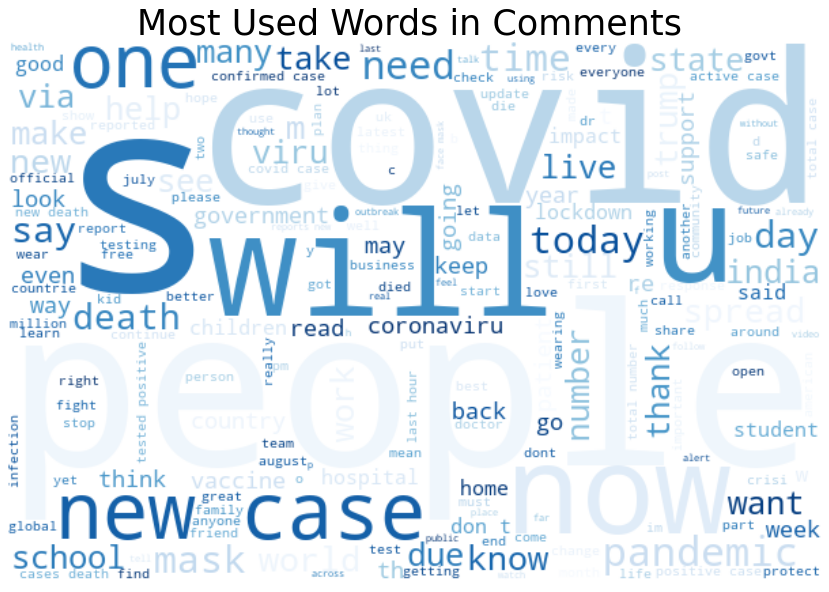

In [66]:
# Most Used Words
fig, (ax2) = plt.subplots(1,1,figsize=[17, 10])
wordcloud2 = WordCloud(background_color='white',
                       colormap="Blues", 
                        width=600,
                       height=400).generate(" ".join(covid['refine_text']))

ax2.imshow(wordcloud2,interpolation='bilinear')
ax2.axis('off')
ax2.set_title('Most Used Words in Comments ',fontsize=35)
plt.show()

In [ ]:
# nltk
import nltk
from PIL import Image
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))
from nltk.util import ngrams

# sklearn
from sklearn import preprocessing
from sklearn import model_selection
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import train_test_split

# import tensorflow
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [67]:
def ngram_df(corpus,nrange,n=None):
    vec = CountVectorizer(stop_words = 'english',ngram_range=nrange).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    total_list=words_freq[:n]
    df=pd.DataFrame(total_list,columns=['text','count'])
    return df
unigram_df=ngram_df(covid['refine_text'],(1,1),20)
bigram_df=ngram_df(covid['refine_text'],(2,2),20)
trigram_df=ngram_df(covid['refine_text'],(3,3),20)

In [70]:
fig = make_subplots(rows=3, cols=1,
                    subplot_titles=("Unigram","Bigram",'Trigram'),
                    specs=[[{"type": "scatter"}],[{"type": "scatter"}],[{"type": "scatter"}]])

fig.add_trace(go.Bar(
    y=unigram_df['text'][::-1],
    x=unigram_df['count'][::-1],
    marker={'color': "blue"},  
    text=unigram_df['count'],
    textposition = "outside",
    orientation="h",
    name="Months",
),row=1,col=1)

fig.add_trace(go.Bar(
    y=bigram_df['text'][::-1],
    x=bigram_df['count'][::-1],
    marker={'color': "blue"},  
    text=bigram_df['count'],
     name="Days",
    textposition = "outside",
    orientation="h",
),row=2,col=1)

fig.add_trace(go.Bar(
    y=trigram_df['text'][::-1],
    x=trigram_df['count'][::-1],
    marker={'color': "blue"},  
    text=trigram_df['count'],
     name="Days",
    orientation="h",
    textposition = "outside",
),row=3,col=1)

fig.update_xaxes(showline=True, linewidth=2, linecolor='black', mirror=True)
fig.update_yaxes(showline=True, linewidth=2, linecolor='black', mirror=True)
fig.update_layout(title_text='Top N Grams',xaxis_title=" ",yaxis_title=" ", showlegend=False,title_x=0.5,
                  height=1200,template="plotly_dark")
fig.show()

In [72]:
sentiment.head()

,target,id,time,query,usr,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [73]:
sentiment=sentiment.sample(int(sentiment.shape[0]*0.4))
sentiment=sentiment[['text','target']]
sentiment['emotion']=np.where(sentiment['target']==0,'negative',np.where(sentiment['target']==2,'neutral',np.where(sentiment['target']==4,'postitive',"none")))
sentiment['target']=np.where(sentiment['target']==4,1,sentiment['target'])

In [74]:
# Optimizing text
sentiment['refine_text']=sentiment['text'].str.lower()
sentiment['refine_text']=sentiment['refine_text'].apply(lambda x:remove_tag(str(x)))
sentiment['refine_text']=sentiment['refine_text'].apply(lambda x:remove_mention(str(x)))
sentiment['refine_text']=sentiment['refine_text'].apply(lambda x:remove_hash(str(x)))
sentiment['refine_text']=sentiment['refine_text'].apply(lambda x:remove_newline(x))
sentiment['refine_text']=sentiment['refine_text'].apply(lambda x:remove_url(x))
sentiment['refine_text']=sentiment['refine_text'].apply(lambda x:remove_number(x))
sentiment['refine_text']=sentiment['refine_text'].apply(lambda x:remove_punct(x))
sentiment['refine_text']=sentiment['refine_text'].apply(lambda x:remove_thi_amp_ha_words(x))
sentiment['refine_text']=sentiment['refine_text'].apply(lambda x:text_strip(x))
sentiment['text_length']=sentiment['refine_text'].str.split().map(lambda x: len(x))

# Removing stopwords
stop_words = set(stopwords.words('english'))
sentiment['refine_text'] =  sentiment['refine_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

In [75]:
train_data=sentiment[['refine_text','target']]

train_set=np.array(train_data['refine_text'])
train_label=np.array(train_data['target'])

x_train, x_test, y_train, y_test = train_test_split(train_set, train_label, test_size=0.20, random_state=42)

In [76]:
# Hyper Parameters
vocab_size = 1000
embedding_dim =16 
max_length = 50
trunc_type='post'
oov_tok = "<OOV>"

In [77]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(x_train)
word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(x_train)
training_padded = pad_sequences(training_sequences,maxlen=max_length, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(x_test)
testing_padded = pad_sequences(testing_sequences,maxlen=max_length)

training_label=y_train
testing_label=y_test

In [78]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')

])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 16)            16000     
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 16,289
Trainable params: 16,289
Non-trainable params: 0
_________________________________________________________________


In [79]:
num_epochs = 12
history=model.fit(training_padded, training_label, epochs=num_epochs, validation_data=(testing_padded, testing_label))

Epoch 1/12
16000/16000 [==============================] - 14s 824us/step - loss: 0.5597 - accuracy: 0.7105 - val_loss: 0.5165 - val_accuracy: 0.7431
Epoch 2/12
16000/16000 [==============================] - 14s 898us/step - loss: 0.5116 - accuracy: 0.7450 - val_loss: 0.5056 - val_accuracy: 0.7483
Epoch 3/12
16000/16000 [==============================] - 15s 916us/step - loss: 0.5063 - accuracy: 0.7472 - val_loss: 0.5068 - val_accuracy: 0.7467
Epoch 4/12
16000/16000 [==============================] - 20s 1ms/step - loss: 0.5040 - accuracy: 0.7475 - val_loss: 0.5028 - val_accuracy: 0.7495
Epoch 5/12
16000/16000 [==============================] - 13s 825us/step - loss: 0.5012 - accuracy: 0.7495 - val_loss: 0.5006 - val_accuracy: 0.7505
Epoch 6/12
16000/16000 [==============================] - 26s 2ms/step - loss: 0.5000 - accuracy: 0.7502 - val_loss: 0.5035 - val_accuracy: 0.7445
Epoch 7/12
16000/16000 [==============================] - 18s 1ms/step - loss: 0.4986 - accuracy: 0.7515 - val

In [80]:
tweet_df['refine_text']=tweet_df['text'].str.lower()
tweet_df['refine_text']=tweet_df['refine_text'].apply(lambda x:remove_tag(str(x)))
tweet_df['refine_text']=tweet_df['refine_text'].apply(lambda x:remove_mention(str(x)))
tweet_df['refine_text']=tweet_df['refine_text'].apply(lambda x:remove_hash(str(x)))
tweet_df['refine_text']=tweet_df['refine_text'].apply(lambda x:remove_newline(x))
tweet_df['refine_text']=tweet_df['refine_text'].apply(lambda x:remove_url(x))
tweet_df['refine_text']=tweet_df['refine_text'].apply(lambda x:remove_number(x))
tweet_df['refine_text']=tweet_df['refine_text'].apply(lambda x:remove_punct(x))
tweet_df['refine_text']=tweet_df['refine_text'].apply(lambda x:remove_thi_amp_ha_words(x))
tweet_df['refine_text']=tweet_df['refine_text'].apply(lambda x:text_strip(x))
tweet_df['text_length']=tweet_df['refine_text'].str.split().map(lambda x: len(x))

In [81]:
sen              = np.array(tweet_df.refine_text)
seq              = tokenizer.texts_to_sequences(sen)
padd             = pad_sequences(seq, maxlen=max_length, truncating=trunc_type)
result           = model.predict(padd)
validated_result = np.where(result>0.5,1,0)

In [82]:
pred_df                   = pd.DataFrame({'text':tweet_df['refine_text'],'pred_sentiment':list(validated_result),'country':tweet_df['filtered_name'],'text_length':tweet_df['text_length']})
pred_df['pred_sentiment'] = np.where(pred_df['pred_sentiment']>0.5,1,0)
pred_df[['text','pred_sentiment']].head(4)

,text,pred_sentiment
11,order here …,1
30,acknowledges lacks rebuilt homes and a hospita...,0
35,our ceo live with wsu talking about “the effec...,1
50,coronavirus testing fiasco st mirren have pled...,1


In [ ]:
d = '../input/twitter/'
bird = np.array(Image.open(d + 'twitter_mask.png'))

fig, (ax2, ax3) = plt.subplots(1, 2, figsize=[30, 15])
wordcloud2 = WordCloud( background_color='white',mask=bird,colormap="Reds",
                        width=600,
                        height=400).generate(" ".join(pred_df[pred_df['pred_sentiment']==0]['text']))
ax2.imshow(wordcloud2)
ax2.axis('off')
ax2.set_title('Negative Sentiment',fontsize=35);

wordcloud3 = WordCloud( background_color='white',mask=bird,colormap="Greens",
                        width=600,
                        height=400).generate(" ".join(pred_df[pred_df['pred_sentiment']==1]['text']))
ax3.imshow(wordcloud3)
ax3.axis('off')
ax3.set_title('Positive Sentiment',fontsize=35);

In [ ]:
print("Average length of Positive Sentiment tweets : {} ".format(round(pred_df[pred_df['pred_sentiment']==1]['text_length'].mean(),2)))
print("Average length of Negative Sentiment tweets : {} ".format(round(pred_df[pred_df['pred_sentiment']==0]['text_length'].mean(),2)))

In [ ]:
fig = go.Figure()

fig.add_trace(go.Violin(y=pred_df[pred_df['pred_sentiment']==1]['text_length'], box_visible=False, line_color='black',
                               meanline_visible=True, fillcolor='green', opacity=0.6,name="Positive",
                               x0='Positive')
             )

fig.add_trace(go.Violin(y=pred_df[pred_df['pred_sentiment']==0]['text_length'], box_visible=False, line_color='black',
                               meanline_visible=True, fillcolor='red', opacity=0.6,name="Negative",
                               x0='Negative')
             )

fig.update_traces(box_visible=False, meanline_visible=True)
fig.update_layout(title_text="Violin - Tweet Length ",
                  title_x=0.5)

fig.show()

In [ ]:
all_pos_country=pred_df[pred_df['pred_sentiment']==1]['country'].value_counts().reset_index().rename(columns={'index':'country','country':'count'})

all_pos_country_df=pd.merge(all_pos_country,country_code[['COUNTRY','CODE']],left_on="country",right_on="COUNTRY",how="left")
all_pos_country_df=all_pos_country_df[all_pos_country_df['COUNTRY'].notnull()]

In [ ]:
fig = go.Figure(data=go.Choropleth(
    locations = all_pos_country_df['CODE'],
    z = all_pos_country_df['count'],
    text = all_pos_country_df['COUNTRY'],
    colorscale = 'greens', 
    autocolorscale=False,
    reversescale=False,
    marker_line_color='darkgray',
    marker_line_width=0.5,
    colorbar_title = '# of Tweets ',
))

fig.update_layout(
    title_text='Tweets over the world - ({} - {})'.format(covid['only_date'].sort_values()[0].strftime("%d/%m/%Y"),
                                                       covid['only_date'].sort_values().iloc[-1].strftime("%d/%m/%Y")),title_x=0.5,
    
    geo=dict(
        showframe=True,
        showcoastlines=False,
        projection_type='equirectangular',
    )
)

fig.show()

In [ ]:
all_pos_country_df[['country','count']][:5]


In [ ]:
all_neg_country=pred_df[pred_df['pred_sentiment']==0]['country'].value_counts().reset_index().rename(columns={'index':'country','country':'count'})

all_neg_country_df=pd.merge(all_neg_country,country_code[['COUNTRY','CODE']],left_on="country",right_on="COUNTRY",how="left")
all_neg_country_df=all_neg_country_df[all_neg_country_df['COUNTRY'].notnull()]

In [ ]:
fig = go.Figure(data=go.Choropleth(
    locations = all_neg_country_df['CODE'],
    z = all_neg_country_df['count'],
    text = all_neg_country_df['COUNTRY'],
    colorscale = 'reds',  
    autocolorscale=False,
    reversescale=False,
    marker_line_color='darkgray',
    marker_line_width=0.5,
    colorbar_title = '# of Tweets',
))

fig.update_layout(
    title_text='Tweets over the world - ({} - {}) '.format(covid['only_date'].sort_values()[0].strftime("%d/%m/%Y"),
                                covid['only_date'].sort_values().iloc[-1].strftime("%d/%m/%Y")),title_x=0.5,
    geo=dict(
        showframe=True,
        showcoastlines=False,
        projection_type='equirectangular',
    )
)

fig.show()


In [ ]:
all_neg_country_df[['country','count']][:5]


In [ ]:
fig, (ax2, ax3) = plt.subplots(1, 2, figsize=[30, 15])
wordcloud2 = WordCloud( background_color='white',mask=bird,colormap="Reds",
                        width=600,
                        height=400).generate(" ".join(pred_df[(pred_df['pred_sentiment']==0)&(pred_df['country']=='United States')]['text']))
ax2.imshow(wordcloud2)
ax2.axis('off')
ax2.set_title('Negative US Bird',fontsize=35);

wordcloud3 = WordCloud( background_color='white',mask=bird,colormap="Greens",
                        width=600,
                        height=400).generate(" ".join(pred_df[(pred_df['pred_sentiment']==1)&(pred_df['country']=='United States')]['text']))
ax3.imshow(wordcloud3)
ax3.axis('off')
ax3.set_title('Positive US Bird',fontsize=35);

In [ ]:
fig, (ax2, ax3) = plt.subplots(1, 2, figsize=[30, 15])
wordcloud2 = WordCloud( background_color='white',mask=bird,colormap="Reds",
                        width=600,
                        height=400).generate(" ".join(pred_df[(pred_df['pred_sentiment']==0)&(pred_df['country']=='India')]['text']))
ax2.imshow(wordcloud2)
ax2.axis('off')
ax2.set_title('Negative India Bird ',fontsize=35);

wordcloud3 = WordCloud( background_color='white',mask=bird,colormap="Greens",
                        width=600,
                        height=400).generate(" ".join(pred_df[(pred_df['pred_sentiment']==1)&(pred_df['country']=='India')]['text']))
ax3.imshow(wordcloud3)
ax3.axis('off')
ax3.set_title('Positive India Bird ',fontsize=35);
